# **Tutorial 7: Impact of Climate Variability - Precipitation**

**Week 1, Day 3, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In this tutorial, the primary goal is to understand how to utilize satellite data to investigate the effects of large-scale climate variability on precipitation.

Upon the completion of this tutorial, you will be able to:

- Comprehend the influence of the El Niño-Southern Oscillation (ENSO) on precipitation and its geographical distribution.
- Compute Pearson's correlation coefficient, a statistical measure used to determine the relationship between two time series.


# **Setup**

In [1]:
# Properly install cartopy in colab to avoid session crash
# !apt-get install libproj-dev proj-data proj-bin --quiet
# !apt-get install libgeos-dev --quiet
# !pip install cython --quiet
# !pip install cartopy --quiet

# !apt-get -qq install python-cartopy python3-cartopy  --quiet
# !pip uninstall -y shapely  --quiet
# !pip install shapely --no-binary shapely  --quiet

In [2]:
# imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import os
import requests
import pooch

In [3]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [6]:
# @title Video 1: Video 1 Name
#Tech team will add code to format and display the video

# **Section 1: ENSO and precipitation**

As discussed in previous tutorials, ENSO oscillates irregularly between El Niño and La Niña phases every two to seven years. These shifts often prompt predictable changes in ocean surface temperature and disrupt wind and rainfall patterns across the tropics, leading to a cascade of global side effects.

In this context, we will be utilizing satellite data to scrutinize the influence of ENSO on precipitation patterns. 

## **Section 1.1: Get ENSO Index Oceanic Niño Index (ONI)**

In last tutorial, we generated the Oceanic Niño Index (ONI) using the OISST Climate Data Records. Now we just read the ONI value using the climatology of 1982-2011.


In [5]:
# download't6_oceanic-nino-index.nc'

url_nino = "https://osf.io/8rwxb/download/"
oni = xr.open_dataset(pooch.retrieve(url_nino,known_hash=None))
oni

<xarray.Dataset>
Dimensions:  (time: 499)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
    month    (time) int32 ...
Data variables:
    sst      (time) float32 ...

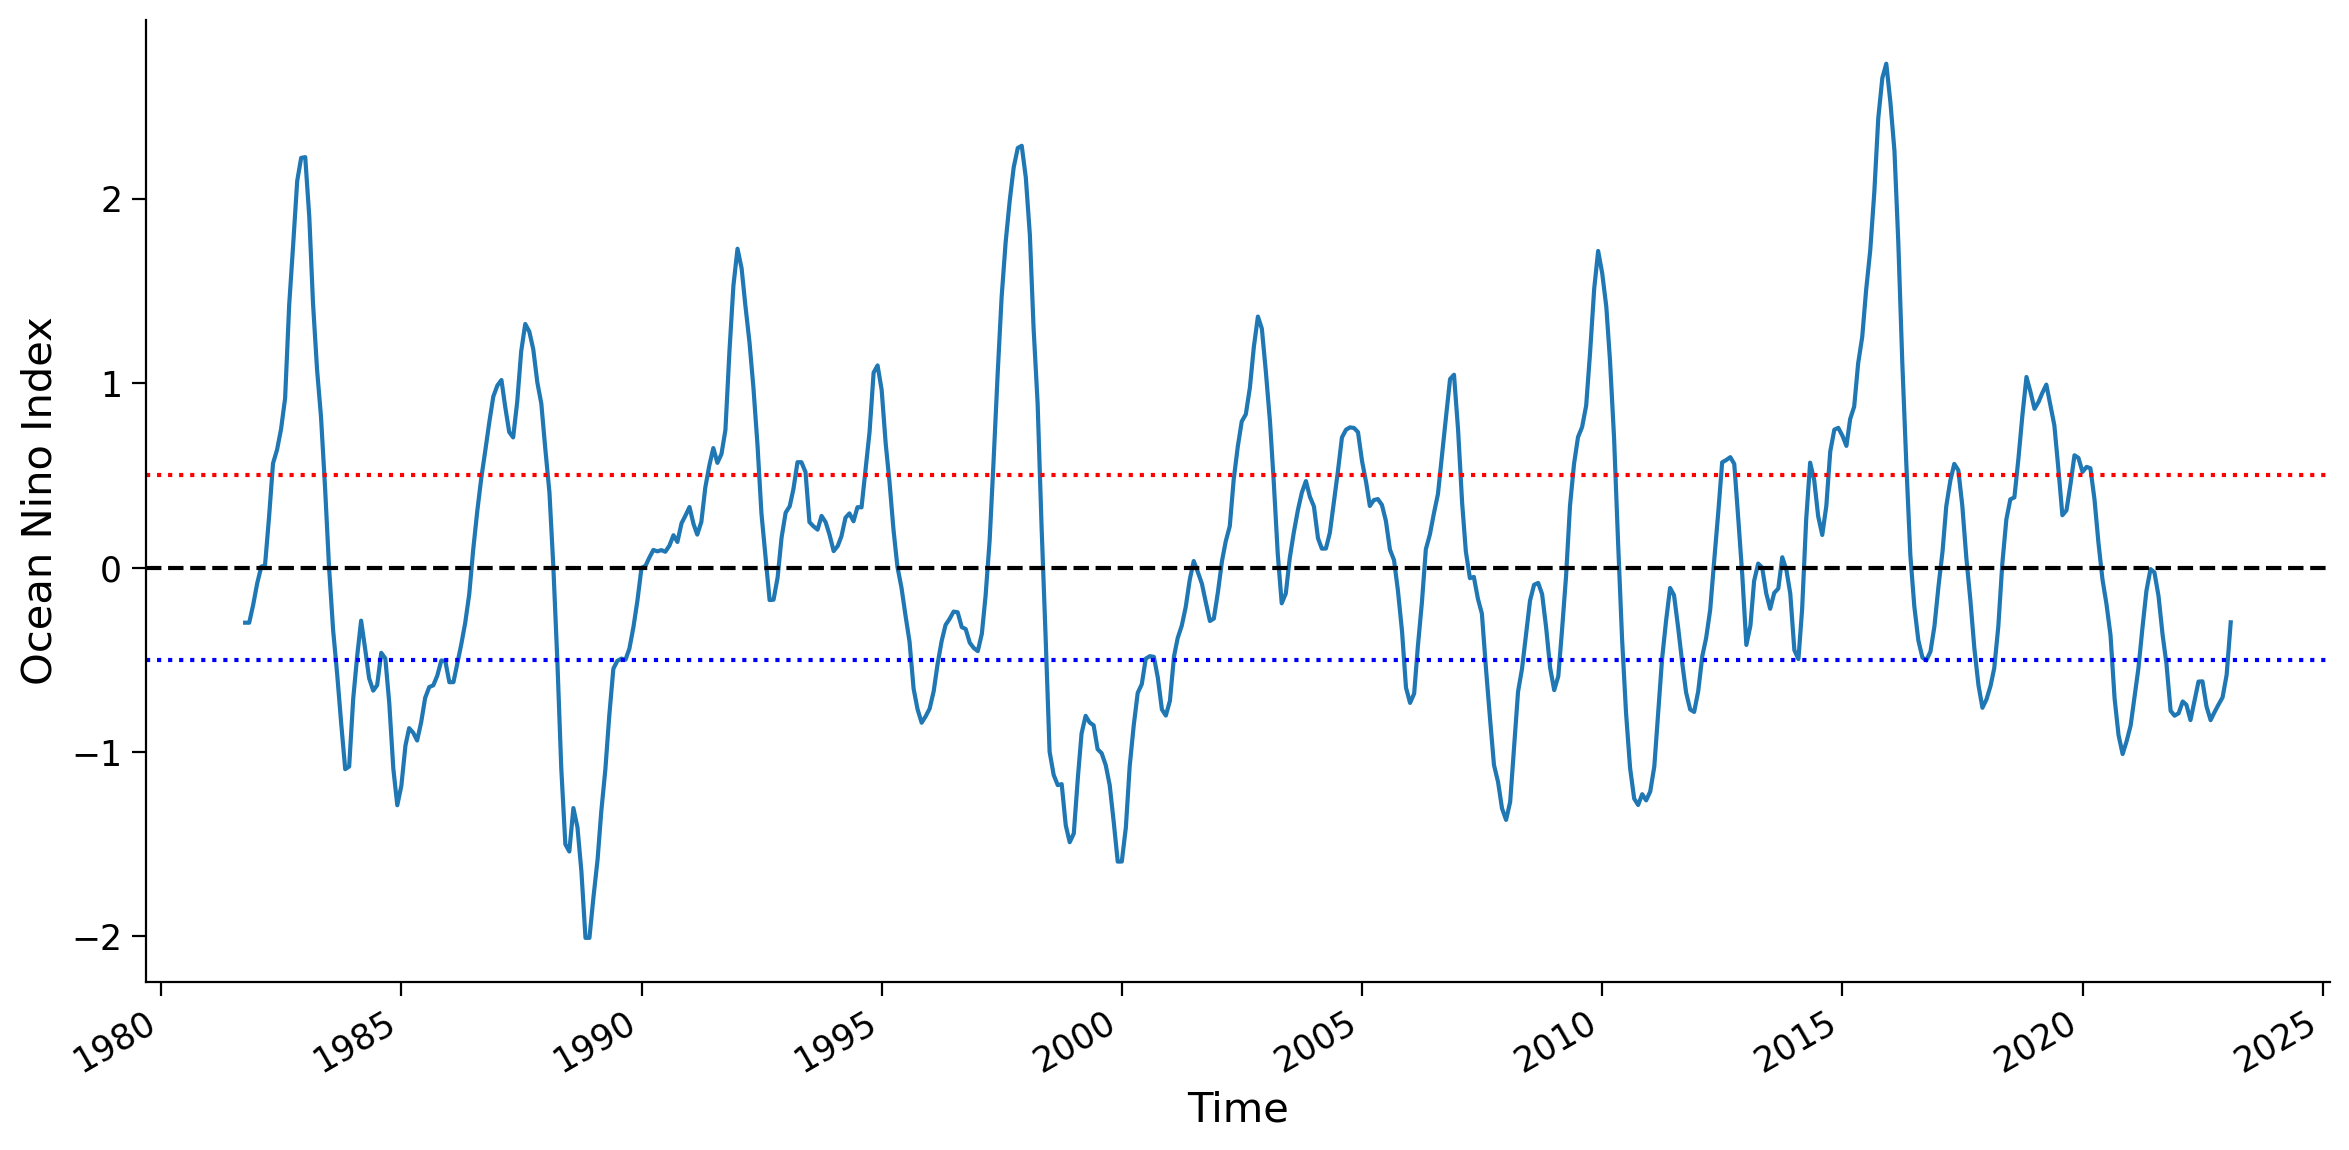

In [6]:
# plot the oni timeseries we just downloaded
fig=plt.figure(figsize=(12,6))
oni.sst.plot()
plt.ylabel('Ocean Nino Index')
plt.axhline(y=0, linestyle='dashed', color='k')
plt.axhline(y=0.5, linestyle='dotted', color='r')
plt.axhline(y=-0.5, linestyle='dotted', color='b')

## **Section 1.2: Get Precipitation Anomaly Data**

In tutorial 5, we created the monthly anomaly data of precipitation globally using the GPCP Monthly Precipitation Climate Data Records. Here, we read in the anomaly data and look at one specific month (e.g., 1998-01-01).

In [7]:
# download file 't5_gpcp-monthly-anomaly_1981-2010.nc'
url_precip = "https://osf.io/vhdcg/download/"
precip = xr.open_dataset(pooch.retrieve(url_precip,known_hash=None))
precip

SHA256 hash of downloaded file: 0d4816ee542ecfed508981a5f5bfefceac3da82bc10b3b739fdf11a85574bc9b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset>
Dimensions:    (time: 528, latitude: 72, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
    month      (time) int32 ...
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
Data variables:
    precip     (time, latitude, longitude) float32 ...

/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


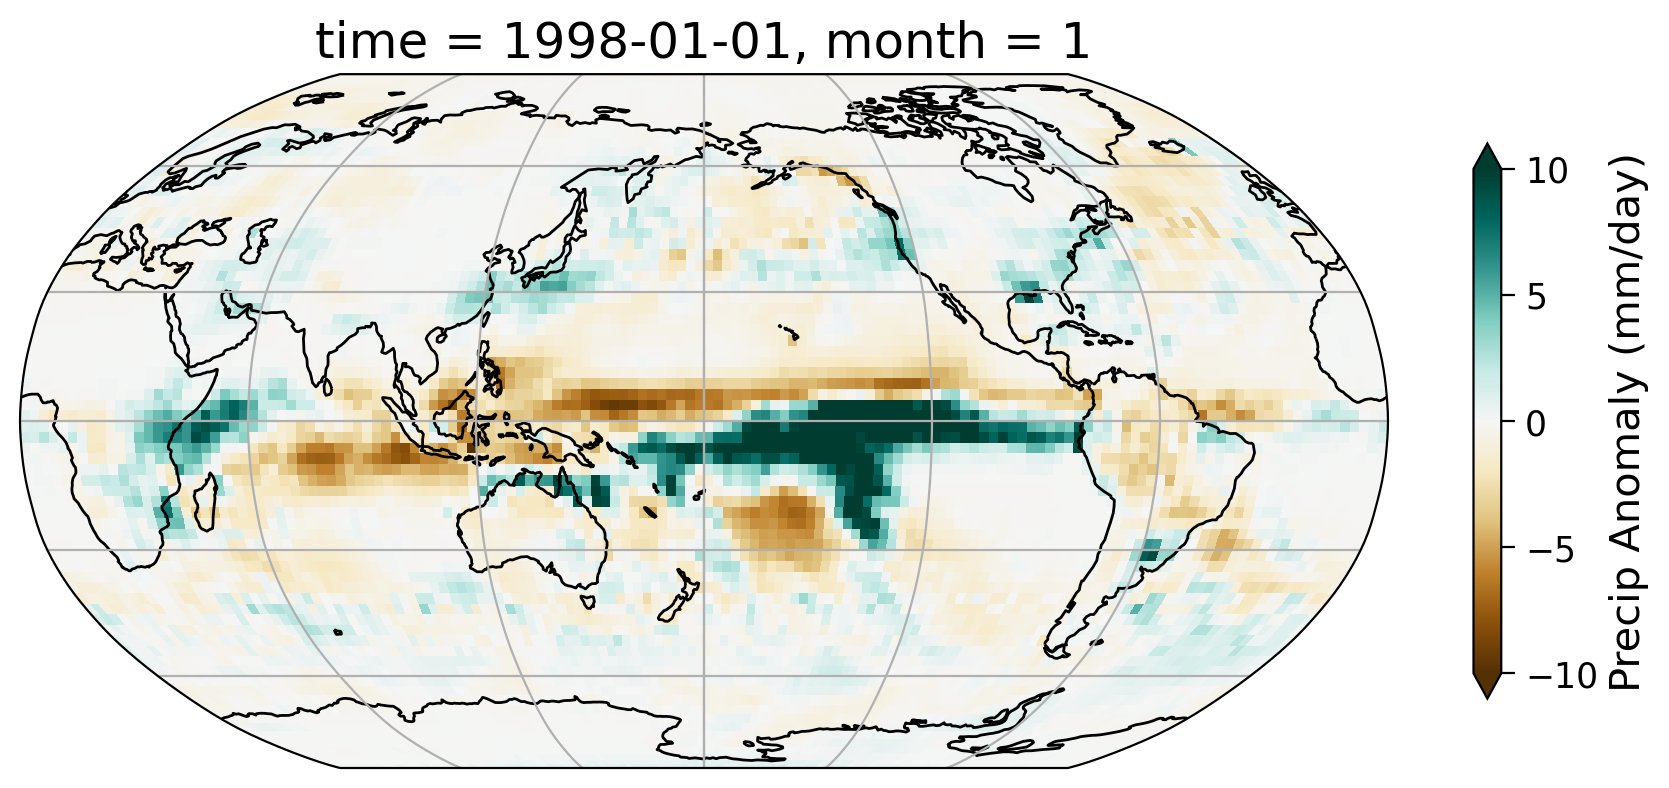

In [8]:
# select just data from 1998
data=precip.sel(time='1998-01-01')

# initate plot
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
data.precip.plot(ax=ax, transform=ccrs.PlateCarree(),
         vmin = -10, vmax = 10, cmap='BrBG',
         cbar_kwargs=dict(shrink=0.5, label='Precip Anomaly (mm/day)'))

## **Section 1.3: Spatial Pattern**

Let's look at one specific ENSO event - the **1997/1998 El Niño** and see how the spatial pattern of the precipitation evolves. The 1997/1998 El Niño is one of the most significant ENSO events that started in May of 1997 and ended April of 1998.

Let's examine the seasonal precipitation anomaly pattern during this time period.

/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/lib/

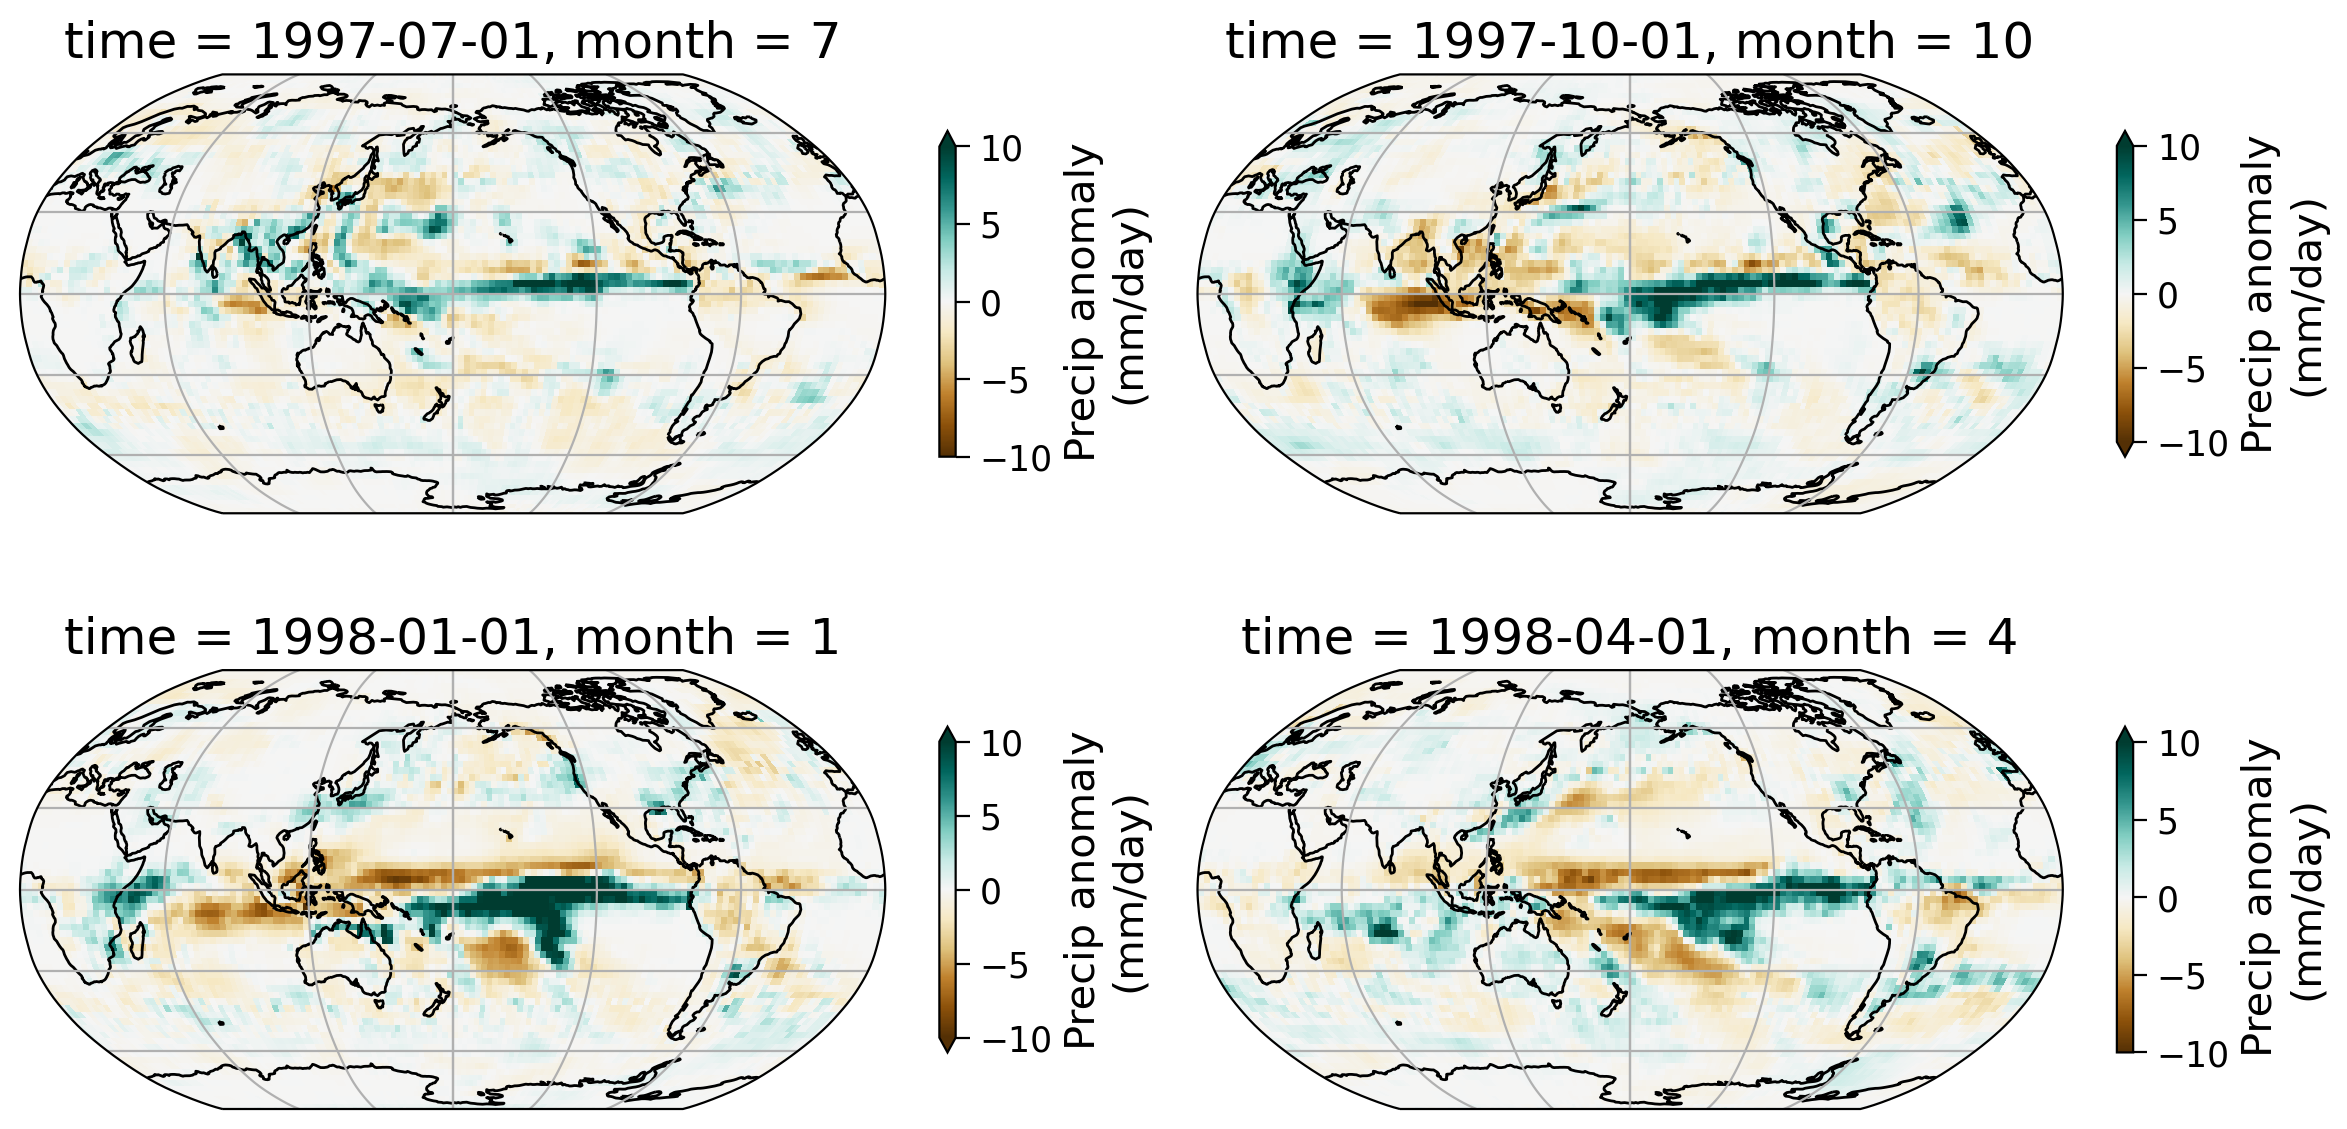

In [9]:
# define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=180)},
                        figsize=(12,7.5), sharex=True, sharey=True)

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

# loop over selected months (Jan, Apr, Jul, Oct)
for i,month in enumerate(['1997-07-01','1997-10-01','1998-01-01','1998-04-01']):

        # draw the coastines and major gridline for each subplot
        axs[i].coastlines()
        axs[i].gridlines()

        # draw the precipitation anomaly data
        precip.precip.sel(time=month).plot(ax=axs[i], transform=ccrs.PlateCarree(),
                   vmin = -10, vmax = 10, # use the same range of max and min value
                   cmap = 'BrBG',
                   cbar_kwargs=dict(shrink=0.4, label='Precip anomaly\n(mm/day)'))

In this series of four monthly maps, notice the shifts in precipitation patterns across the tropics and various land regions.

In particular there are large increases and decreases in precipitation over the tropical ocean, where ENSO is actively monitored. In the Nino 3.4 region, the intensification of the El Niño phase from  (which is characterized by warmer SSTs over the central and eastern Pacific) occurs alongside an increase in rainfall shown here (more blue ares near the equator).

In addition to these changes, there are also rainfall patterns in other parts of the tropics, as well as in North and South America, with the Amazon as a notable example. 

# **Section 2: Correlation Analysis**

Beyond visual inspection, we can also quantify the correlation between the ENSO (ONI) and the precipitation anomaly for a region of our interest.

Let's use Niño 3.4 region as an example to calculate the correlation berween precipitation and ONI.

In [10]:
# extract precipitation data for the Nino 3.4 region & the same time period with ONI data
precip_nino34 = precip.sel(latitude=slice(-5,5),
                           longitude=slice(190,240),
                           time=slice('1981-09-01', '2022-12-01'))
precip_nino34

<xarray.Dataset>
Dimensions:    (time: 496, latitude: 4, longitude: 20)
Coordinates:
  * time       (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2022-12-01
    month      (time) int32 ...
  * longitude  (longitude) float32 191.2 193.8 196.2 198.8 ... 233.8 236.2 238.8
  * latitude   (latitude) float32 -3.75 -1.25 1.25 3.75
Data variables:
    precip     (time, latitude, longitude) float32 ...

In [12]:
# calculate regional mean of the precipitation anomaly
precip_nino34_mean = precip_nino34.mean(('latitude', 'longitude'))

# extract ONI value for the common period (ending at 2022-12-01)
nino34 = oni.sel(time=slice('1981-09-01', '2022-12-01'))

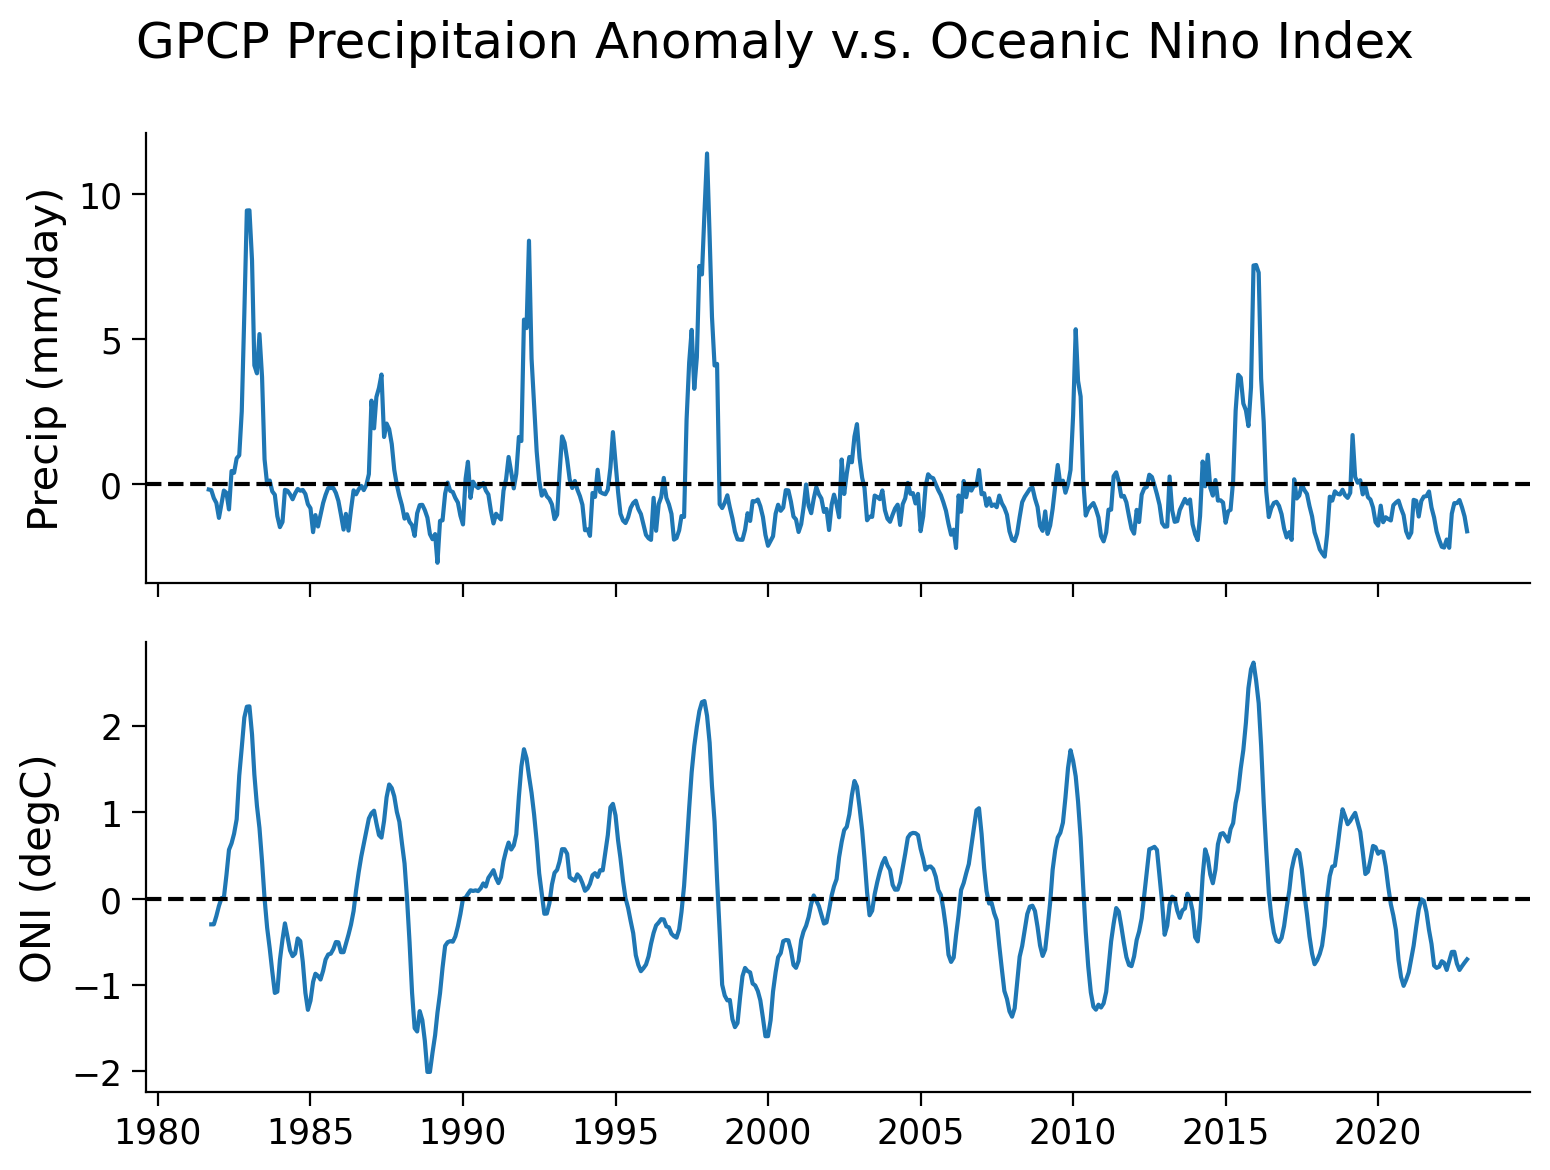

In [14]:
# set up two subplots that share the x-axis to compare precipitation anomaly and ONI index
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('GPCP Precipitaion Anomaly v.s. Oceanic Nino Index')
axs[0].plot(precip_nino34_mean.time, precip_nino34_mean.precip)
axs[0].set_ylabel('Precip (mm/day)')
axs[0].axhline(y=0, color='k', linestyle='dashed')
axs[1].plot(nino34.time, nino34.sst)
axs[1].set_ylabel('ONI (degC)')
axs[1].axhline(y=0, color='k', linestyle='dashed')

From theses two time series, a pattern exists of a synchronized change in the precipitation anomaly and ONI. Now, we can generate a scatter plot to further examine this relationship.

Text(0, 0.5, 'Precipitation Anomaly (mm/day)')

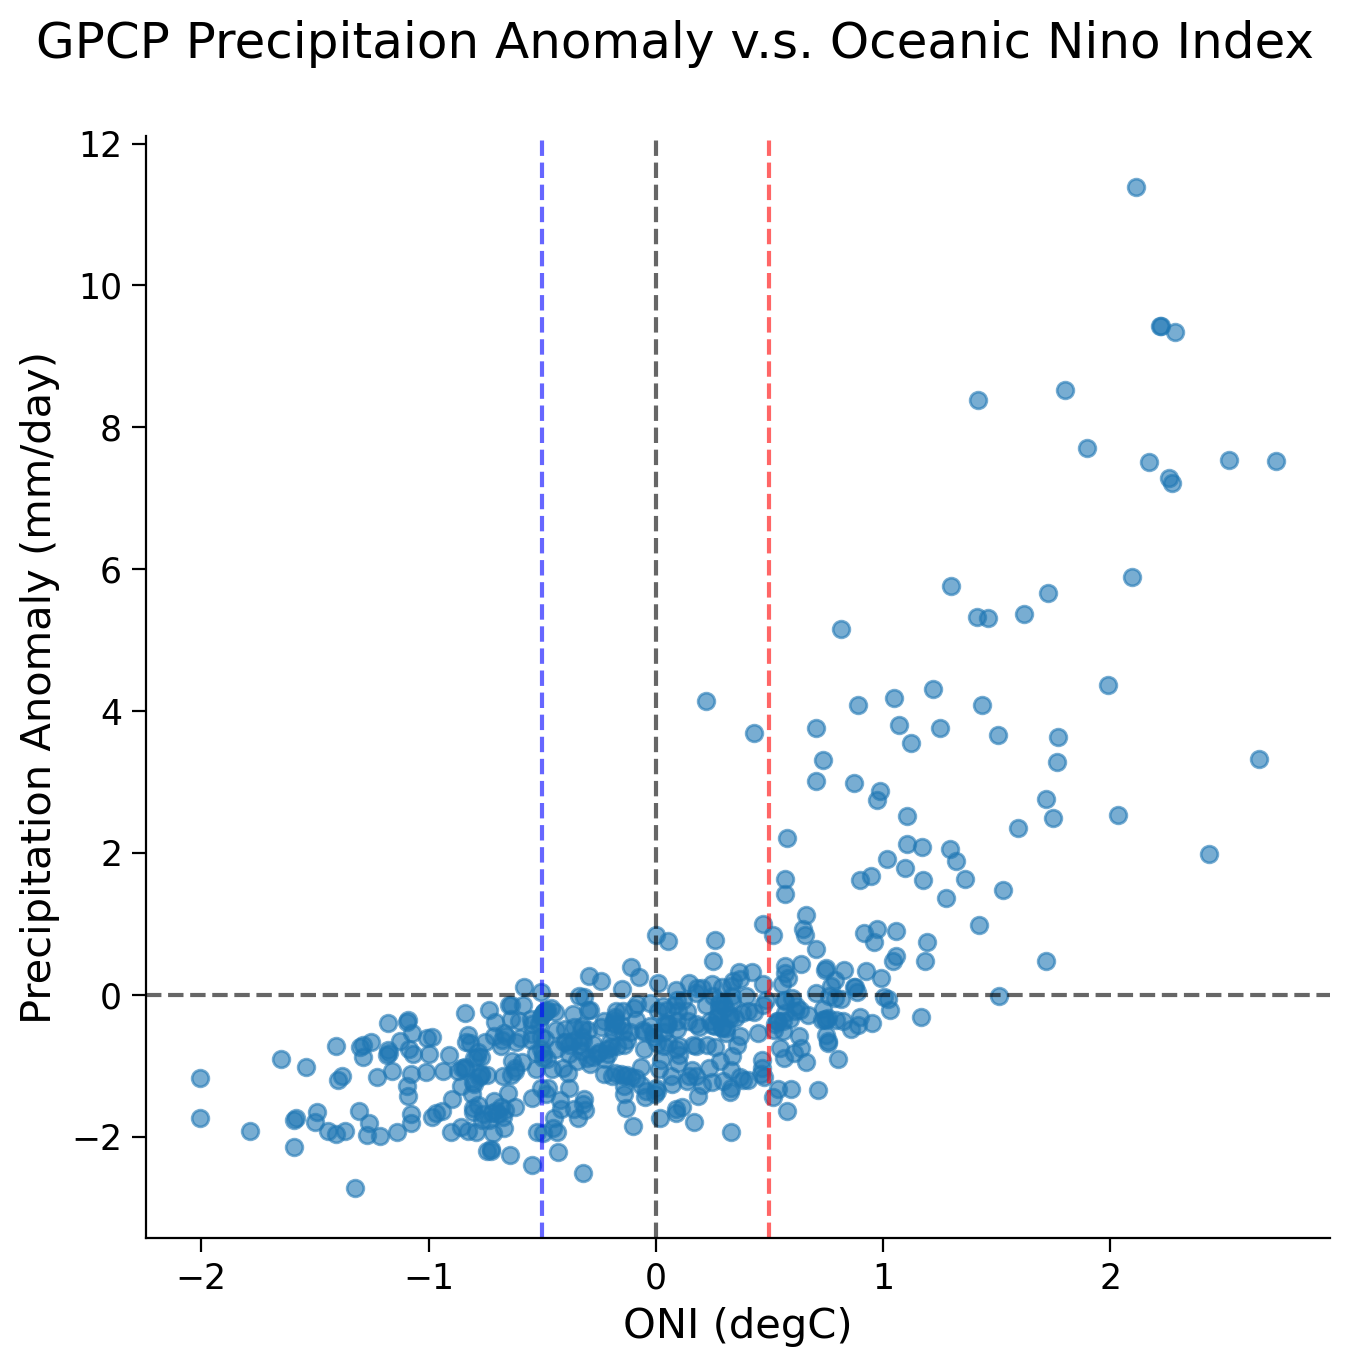

In [15]:
# set up scatter plot
fig = plt.figure(figsize=(7,7))
fig.suptitle('GPCP Precipitaion Anomaly v.s. Oceanic Nino Index')
plt.scatter(nino34.sst, precip_nino34_mean.precip, alpha=0.6)

# add horizontal and vertical lines of 0 values
plt.axhline(y=0, linestyle='dashed', color='k', alpha=0.6)
plt.axvline(x=0, linestyle='dashed', color='k', alpha=0.6)
plt.axvline(x=0.5, linestyle='dashed', color='r', alpha=0.6) #El Nino threshold
plt.axvline(x=-0.5, linestyle='dashed', color='b', alpha=0.6) #La Nina threshold
plt.xlabel('ONI (degC)')
plt.ylabel('Precipitation Anomaly (mm/day)')

The scatter plot unveils a nonlinear relationship between precipitation anomalies and the ONI across different ENSO phases:

- During the La Niña phase (i.e., when ONI values fall below -0.5/ the blue line), the Nino 3.4 region typically experiences below-average precipitation.
- In contrast, during the El Niño phase (i.e., when ONI values rise above 0.5/ the red line), the Nino 3.4 region is inclined towards above-average precipitation.

Moving forward, we will calculate the linear correlation coefficient between the precipitation anomaly and ONI values using the `.corr()` method from the `xarray` library. 

In [16]:
# calculate the linear correlation coefficient using `.corr()`
xr.corr(nino34.sst, precip_nino34_mean.precip)

<xarray.DataArray ()>
array(0.72492704)

In [26]:
from scipy import stats

# sst_nonan = nino34.sst

r,p = stats.pearsonr(nino34.sst.dropna(dim = 'time'), precip_nino34_mean.precip.dropna(dim = 'time'))

ValueError: x and y must have the same length.

The correlation coefficient of 0.72 indicates that the two variables are highly correlated, which confirms our observation based on the time series.

Now can you take a look at other regions such as Amazon rainforest to see if ENSO affects the rainfall pattern there?

## **Coding Exercises 2**

You can choose a region of your interest to examine the relationship between ENSO (using ONI data) and precipitation anomaly globally. 

In [17]:
################################################################################
# Exercise: Examine relationship between ENSO and precipitation anomaly.       #
################################################################################

# Step 1: Define region of interest for the precipitation anomaly

# Step 2: Calculate regional mean time series

# Step 3: Plot the time serise of precipitation anomaly and ONI for the same
#         time period using two subplots

# Step 4: Plot scatter plot between precipitation and ONI

# Step 5: Calculate correlation coefficient

# Step 6: Create maps to examine the spatial pattern of a significant ENSO phase
#         (e.g., 1997/1998 El Nino or 1988/1989 La Nina)


# ohad comment: I'll remove step 6. plotting the entire globe again? what for? 

'''

Please describe the relationship between the ENSO and the regional precipitation
pattern:

'''

'\n\nPlease describe the relationship between the ENSO and the regional precipitation\npattern:\n\n'

Italy ONI precipt correlation:<xarray.DataArray ()>
array(0.01532387)


'\n\nPlease describe the relationship between the ENSO and the regional precipitation\npattern:\n\n'

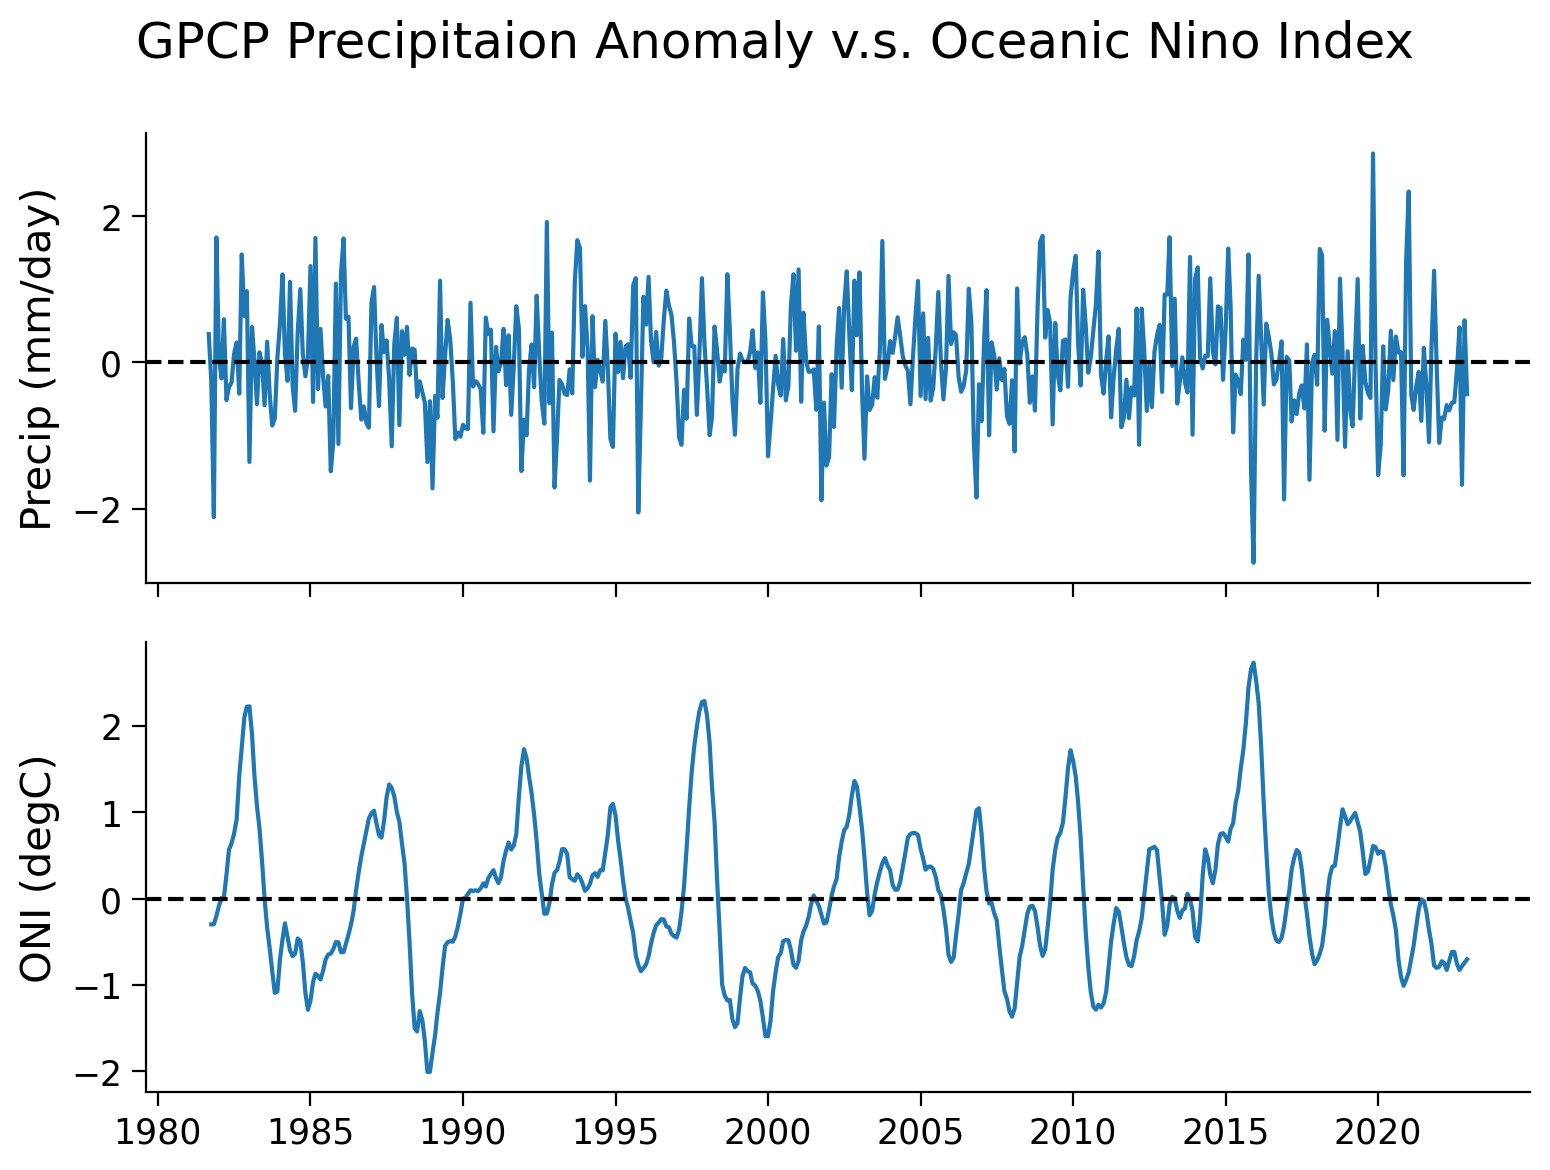

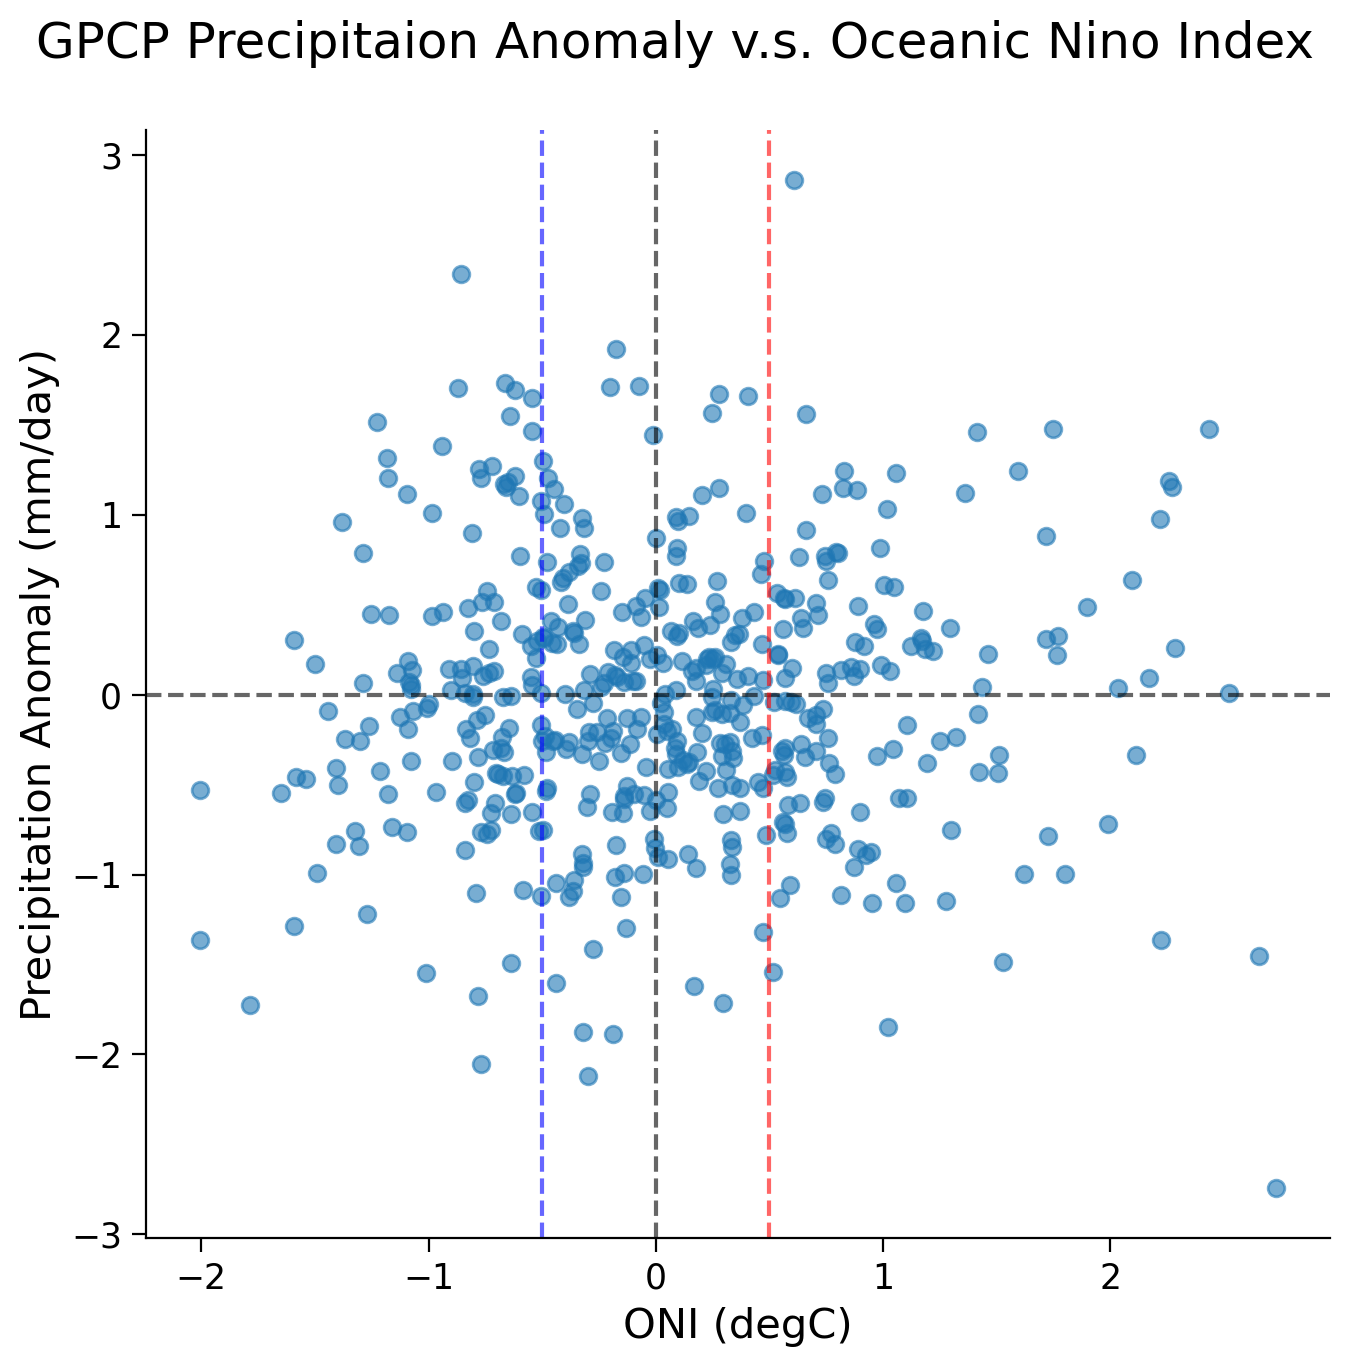

In [19]:
# to remove solution

################################################################################
# Exercise: Examine relationship between ENSO and precipitation anomaly.       #
################################################################################

# Step 1: Define region of interest for the precipitation anomaly
# Italy lot and lan:
italy_lon=[6,19]
italy_lat=[36,48]

# Step 2: Calculate regional mean time series
precip_nino34_italy = precip.sel(latitude=slice(italy_lat[0],italy_lat[1]),
                           longitude=slice(italy_lon[0],italy_lon[1]),
                           time=slice('1981-09-01', '2022-12-01')).mean(dim=('latitude', 'longitude'))
# Step 3: Plot the time serise of precipitation anomaly and ONI for the same
#         time period using two subplots

fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('GPCP Precipitaion Anomaly v.s. Oceanic Nino Index')
axs[0].plot(precip_nino34_italy.time, precip_nino34_italy.precip)
axs[0].set_ylabel('Precip (mm/day)')
axs[0].axhline(y=0, color='k', linestyle='dashed')
axs[1].plot(nino34.time, nino34.sst)
axs[1].set_ylabel('ONI (degC)')
axs[1].axhline(y=0, color='k', linestyle='dashed')

# Step 4: Plot scatter plot between precipitation and ONI

fig = plt.figure(figsize=(7,7))
fig.suptitle('GPCP Precipitaion Anomaly v.s. Oceanic Nino Index')
plt.scatter(nino34.sst, precip_nino34_italy.precip, alpha=0.6)
# Add horizontal and vertical lines of 0 values
plt.axhline(y=0, linestyle='dashed', color='k', alpha=0.6)
plt.axvline(x=0, linestyle='dashed', color='k', alpha=0.6)
plt.axvline(x=0.5, linestyle='dashed', color='r', alpha=0.6) #El Nino threshold
plt.axvline(x=-0.5, linestyle='dashed', color='b', alpha=0.6) #La Nina threshold
plt.xlabel('ONI (degC)')
plt.ylabel('Precipitation Anomaly (mm/day)')

# Step 5: Calculate correlation coefficient
print('Italy ONI precip correlation:'+str(xr.corr(nino34.sst, precip_nino34_italy.precip)))

'''

Please describe the relationship between the ENSO and the regional precipitation
pattern:

'''

# **Summary**
In this tutorial, we've acquired skills to evaluate the connection between precipitation and large-scale climate variability by analyzing Oceanic Nino Index (ONI) using the OISST Climate Data Records.

- We've discovered that the ENSO significantly influences precipitation patterns in the tropics, with this impact rippling out to other regions across the globe.
- Pearson's correlation coefficient proves to be a useful tool to investigate potential correlations. However, it's critical to further scrutinize these correlations with physical explanations to ensure that any detected signals are meaningful and not mere coincidences.
